In [1]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


# Example random function

We start with our target function which is just a 2D Gaussian mixture with random centers and variances.

In [2]:
class random2DGausianMixture(object):
    def __init__(self,xyrange,n,sigma):
        self.centers = [(xyrange[0]*rand(),xyrange[1]*rand()) for i in range(n)]
        self.amplitudes = 10*rand(n)
        self.sigmas = 0.3*np.mean(xyrange)*rand(n)
        self.noise_sigma = sigma
        
    def G(self,r,center,sigma,amp):
        return amp*np.exp(-np.sum((r-center)**2)/(2*sigma**2))
    
    def __call__(self,r):
        gs = [self.G(r,c,s,a) \
                    for c,s,a in zip(self.centers,self.sigmas,self.amplitudes)]
        return -np.sum(gs) + self.noise_sigma*randn()

#create a function on x in [0,10] and y in [0,8] with 6 centers and no noise.
f = random2DGausianMixture((10,8),5,0.)

In [3]:
# plot the example function with the center and minimum
@vectorize
def vec_f(x,y):
    return f(array((x,y)))

f.noise_sigma=0.
x=arange(-5,15,.1)
y=arange(-5,13,.1)
X,Y = meshgrid(x,y)
F=vec_f(X,Y)
xc=array([c[0] for c in f.centers])
yc=array([c[1] for c in f.centers])

<IPython.core.display.Javascript object>


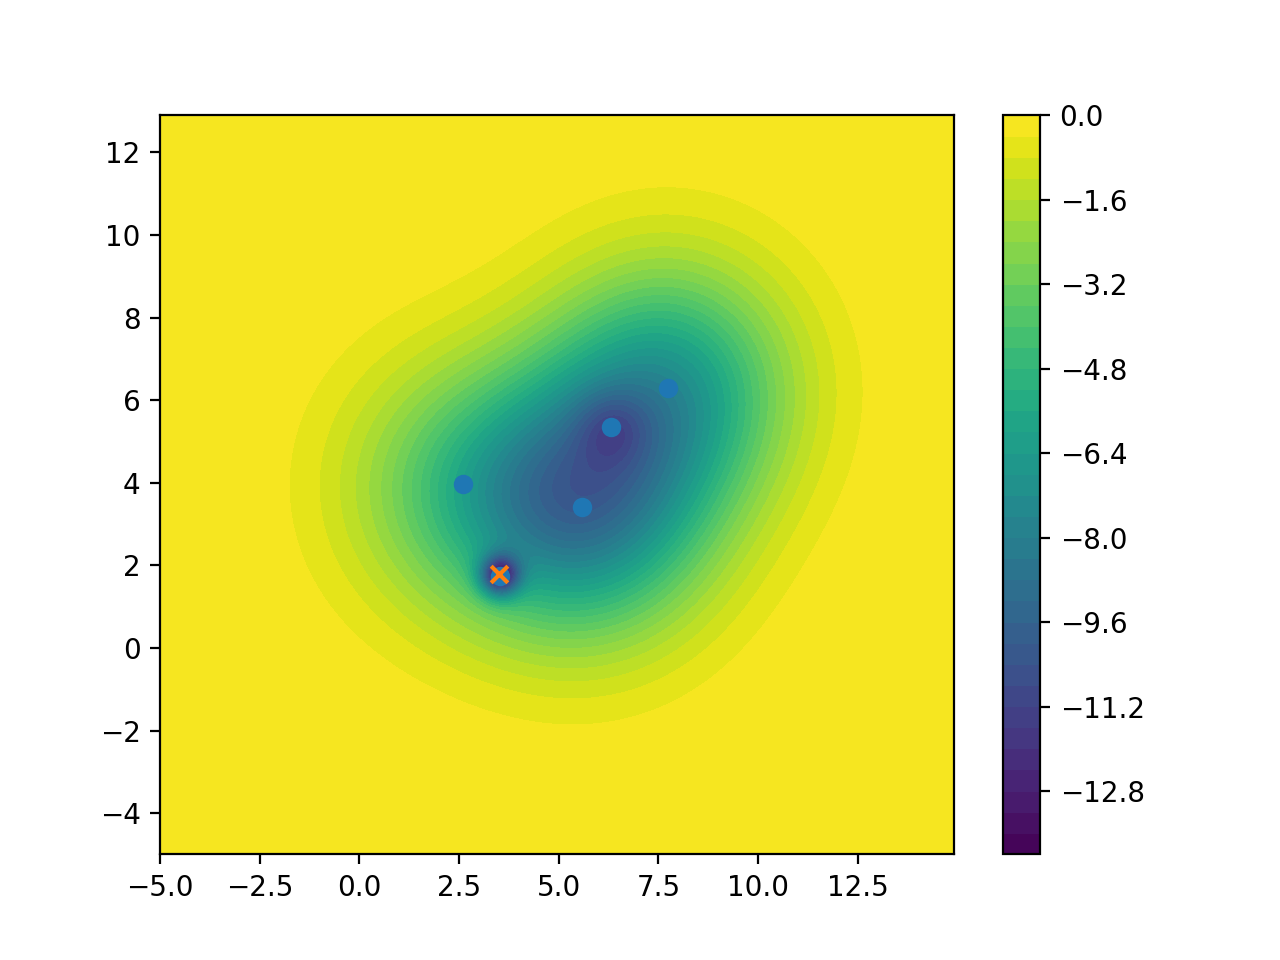

In [4]:
close()
#ploting the function
contourf(X,Y,F,40)
colorbar()
#gauusian centers
scatter(xc,yc)
#global minimum
real_min_ind = argmin(F.flatten())
scatter(X.flatten()[real_min_ind],Y.flatten()[real_min_ind],marker='x')
#xlim(0,10)
#ylim(0,8)
#set noise level for simulation
f.noise_sigma=0.5

# Plotting

We first define some plotting functions to have some fun graphics during the simulation

In [5]:

from numpy import linspace, meshgrid
from matplotlib.mlab import griddata

def grid(x, y, z, resX=100, resY=100):
    "Convert 3 column data to matplotlib grid"
    xi = linspace(min(x), max(x), resX)
    yi = linspace(min(y), max(y), resY)
    Z = griddata(x, y, z, xi, yi,interp='linear')
    X, Y = meshgrid(xi, yi)
    return X, Y, Z

def init_plot():
    
    #XY = array([manager.gmap.unit_to_list(c) for c in manager.complete])
    XY_pending = array([manager.gmap.unit_to_list(c) for c in manager.pending])
    ms=5
    close()
    fig=figure(figsize=[18/2,12/2])
    ax1=subplot(121)
    cont1=contourf(X,Y,F,20)
    
    l_complete={}
    l_complete['grid'] = plot([],[],'ks',alpha=0.5)[0]
    l_complete['Thompson'] = plot([],[],'r.',alpha=0.5)[0]
    l_complete['poll'] = plot([],[],'bx',alpha=0.5)[0]
    l_complete['random'] = plot([],[],'o',color='0.5',alpha=0.5)[0]

    #l_complete = plot([],[],ls='none',marker='o',ms=ms,color='b')
    l_pending = plot(XY_pending[:,0],XY_pending[:,1],ls='none',marker='o',ms=ms,color='0.5')
    #best_run = argmin(manager.values)
    l_best = plot([],[],ls='none',marker='o',ms=ms,color='r')
    real_min_ind = argmin(F.flatten())
    scatter(X.flatten()[real_min_ind],Y.flatten()[real_min_ind],marker='x',color='g')
    xlim(-5,15)
    ylim(-5,13)
    

    ax2=subplot(122)
    xlim(-5,15)
    ylim(-5,13)

    tight_layout()
    fig.canvas.draw()
    
    
    return fig,ax1,ax2,l_complete,l_pending[0],l_best[0]


def update_plot():
    XY = array([manager.gmap.unit_to_list(c) for c in manager.complete])
    XY_pending = array([manager.gmap.unit_to_list(c) for c in manager.pending])
    ind = lambda s: array(manager.types)==s
    
    if len(manager.values)>0:
        for point_type in l_complete.keys():
            l_complete[point_type].set_data(XY[ind(point_type),0],XY[ind(point_type),1])
        best_run = argmin(manager.values)
        l_best.set_data(XY[best_run,0],XY[best_run,1])
    if len(manager.values)>3:
        Xx, Yy, Zz = grid(XY[:,0],XY[:,1],array(manager.values))
        ax2.clear()
        ax2.contourf(Xx, Yy, Zz,20)
        ax2.scatter(XY[best_run,0],XY[best_run,1],color='r')
        ax2.set_xlim(-5,15)
        ax2.set_ylim(-5,13)
    if len(XY_pending)>0:
        l_pending.set_data(XY_pending[:,0],XY_pending[:,1])
    else:
        l_pending.set_data([],[])
    fig.canvas.draw()
    plt.show()

## Ipyparallel setup

In [6]:
import ipyparallel as ipp
# We assume the ipyparallel cluster is running
# creating a client direct view and load balance view
ipp_client = ipp.Client()
ipp_dview = ipp_client.direct_view()
ipp_lbview = ipp_client.load_balanced_view()
ipp_client.clear()

/usr/local/lib/python3.6/dist-packages/ipyparallel/client/client.py:458: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@parker')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


<Future at 0x7fa1ac0446a0 state=pending>

In [7]:
%%px 
import os
#change dir of engines to current dir so the could import minimint
os.chdir("/home/ranr/GoogleDrive/RanWork/miniBOP/")

Some remote imports on theh engiens

In [8]:
%%px
import time
import numpy as np
from numpy.random import rand, randn


send the target function to all engine

In [9]:
a=ipp_dview.push({'random2DGausianMixture':random2DGausianMixture})
a=ipp_dview.push({'f':f})
#a.wait()
#a.successful()
a.get()

[None, None, None, None, None, None, None, None]

In [10]:
ipp_dview.scatter('engine_id',ipp_client.ids)

<AsyncResult: scatter>

In [11]:
ipp_dview['seed']=876897131
a=ipp_dview.execute('np.random.seed(seed+engine_id[0])')
a.get()

[, , , , , , , ]

# Setup for MinBOP


We create choosers on engines and define the point selection function

In [15]:
%%px --local
import time
import importlib


import miniBOP.chooser.BOP_Chooser
import miniBOP.chooser.FuBarVarCtrl_Chooser
importlib.reload(miniBOP.chooser.BOP_Chooser)
importlib.reload(miniBOP.chooser.FuBarVarCtrl_Chooser)
from miniBOP.chooser.BOP_Chooser import BOP_Chooser
from miniBOP.chooser.FuBarVarCtrl_Chooser import FuBarVarCtrl_Chooser

In [27]:
%%px
#chooser = BOP_Chooser(2)
chooser = FuBarVarCtrl_Chooser(2)

# chooser performs MCMC iterations over GP hyperparameters to reach equilibrium.
chooser.T_MCMC = 40
chooser.min_n_points_for_inference = 8
chooser.rho = 0.5
chooser.l_poll = 1.5
chooser.hypers_sampler.lambda_length = 0.3
chooser.z = 10.

Define the function we will use to run the "simulation" on the engines.

In [28]:
import time

def run_job(params):
    '''
    this function takes parameters from the MinimintOptimizer and runs a simulation 
    with those parameters.
    it should return the job_id as well so that the MinimintOptimizer will be 
    able to asociate the results with the right parameters.
    '''
    # process the parameters 
    x = params[0]
    y = params[1]
    
    # run 'simulation'
    val = f(np.array((x,y)))
    dur = 10*np.random.rand()
    #time.sleep(dur)
    
    # return results 
    return val

Create optimizer object and manager object (to keep track of BO results)

In [29]:
from miniBOP.BO_Manager import BO_Manager
from miniBOP.IPP_ParOptimizer import IPP_ParOptimizer, IpyparallelStaticManager

#define the hyperparameters we want to optimize
#Unlike in spearmint-lite, this should eb a LIST of dictionaries. 
#This mantains the order of variables in the hypercube unnits vector of the params 
#"size" is the dimentionality of the prameter
variables = [
{
  "name":"X",
  "type":"float",
  "min":-5,
  "max":15,
  "size":1
},
{
  "name":"Y",
  "type":"float",
  "min":-5,
  "max":13,
  "size":1
}
]

#create manager, cluster_manager, and optimizer. 

manager = BO_Manager(variables,len(ipp_lbview),10)
cluster_manager = IpyparallelStaticManager(ipp_client)
optimizer = IPP_ParOptimizer(manager,cluster_manager,\
                             process_sim_results = lambda res,info: (res,res),\
                             save_results = lambda l: update_plot(),\
                             run_job = run_job,\
                             select_point = lambda c,v,p: chooser.next(c,v,p),\
                             pre_init = None,
                             post_optimization = None)
optimizer.min_n_save = 1 # to call update_plot every time there is a change
optimizer.t_sleep = 0.1 # time between initial jobs
optimizer.max_n_jobs = 200 # max number of points to evaluate


# Optimization using Ipyparaller and Minimint

<IPython.core.display.Javascript object>


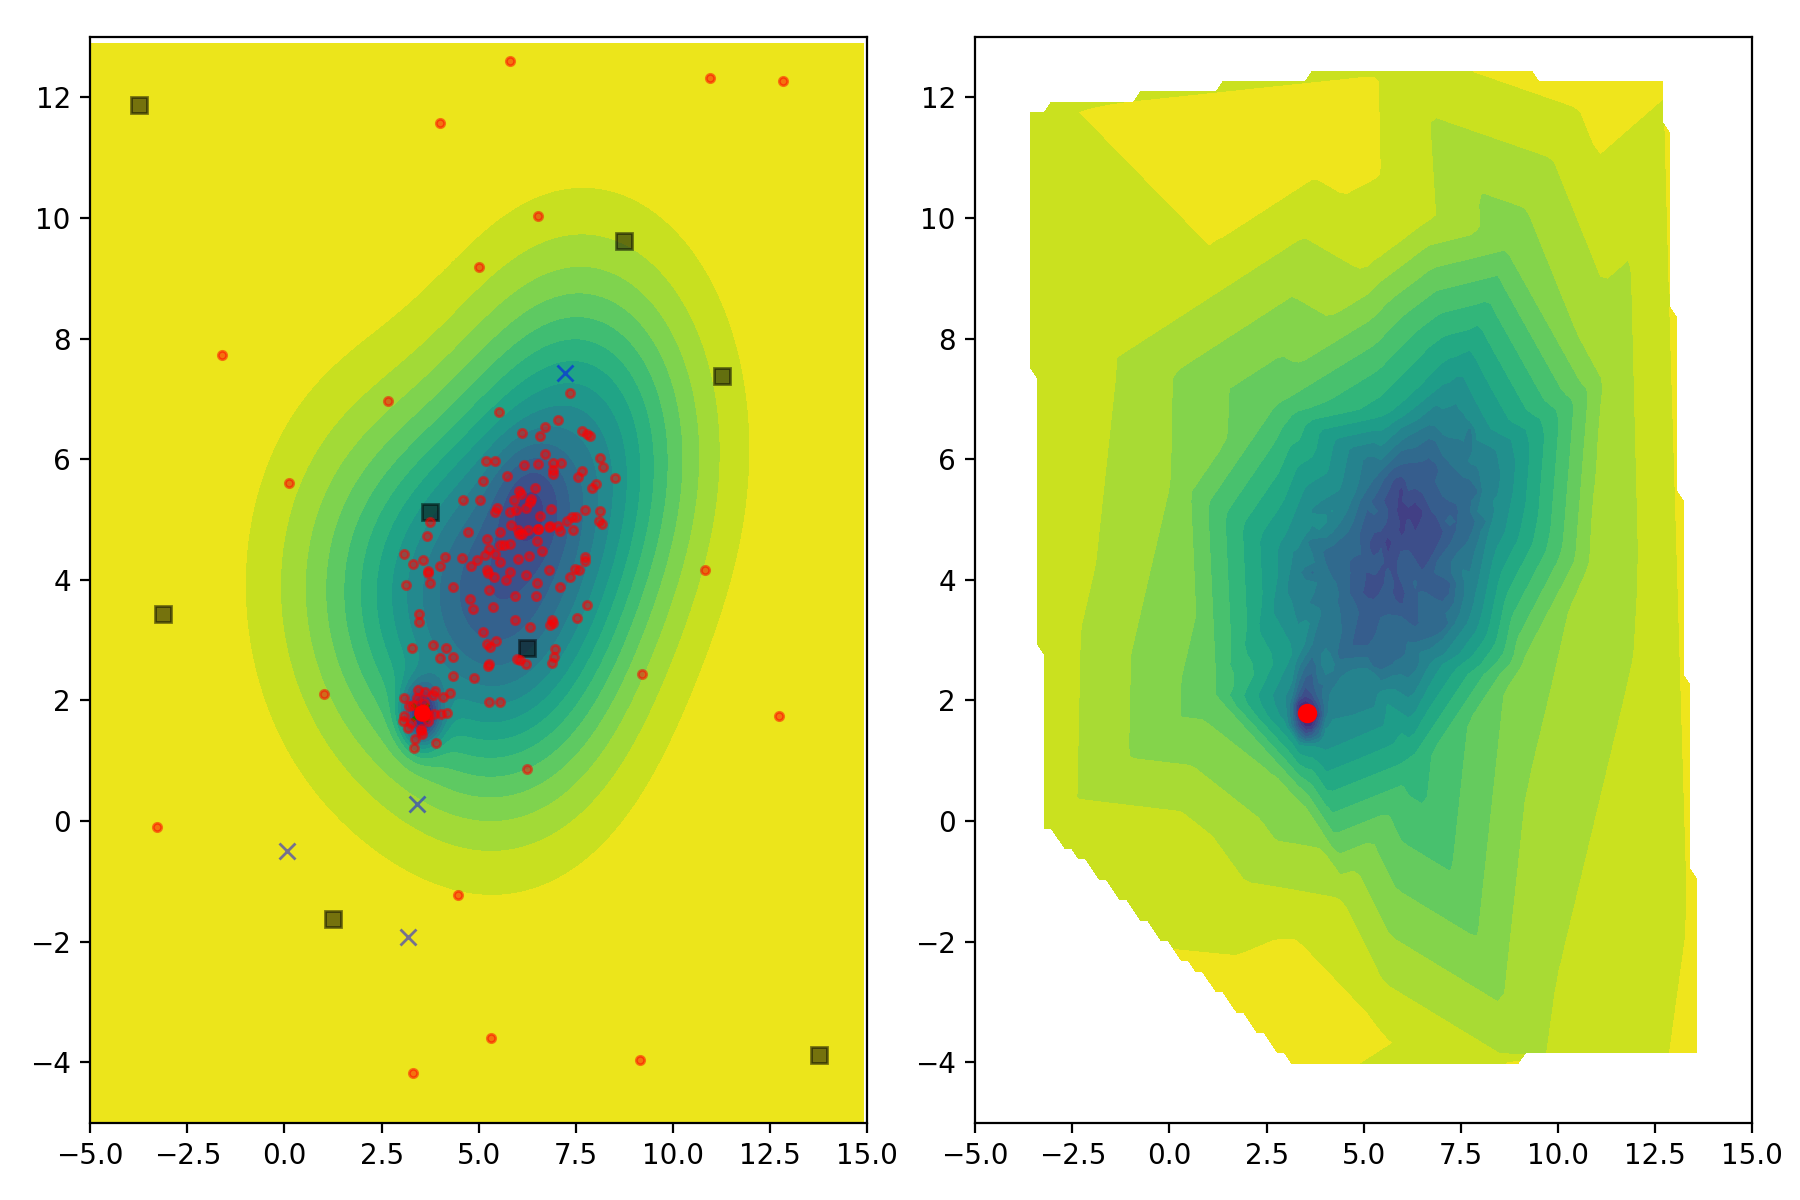

In [30]:
# Show a plot to monitor the simulation
fig,ax1,ax2,l_complete,l_pending,l_best=init_plot() 

In [31]:
optimizer.max_n_jobs = 200 # max number of points to evaluate
optimizer.submit_init() # submits initial points from grid. 
# Can also be used to resume failed optimizations
# given a properly initialized MinimintAsyncManager 
# (with the previous complete,value and pending lists)
#optimizer.max_n_jobs = 400
optimizer.optimize(wait_time=1e-2) # run optimization. Waiting 1e-2 sec between cluster job checks.


11:49:43 Submited 8 jobs. n_jobs=8, N_sim=8, N_BO=0

Monitoring results
Recived job_id 6, val=-0.154, dur=0.0187
Recived job_id 4, val=-1.39, dur=0.01716
Recived job_id 0, val=-2.12, dur=0.005907
Recived job_id 5, val=-8.54, dur=0.02016
Recived job_id 3, val=-0.0829, dur=0.02028
Recived job_id 2, val=-7.44, dur=0.01869
Recived job_id 7, val=-0.284, dur=0.01902
Recived job_id 1, val=0.224, dur=0.00828

11:49:43 Submited 8 chooser jobs. n_jobs=16, N_sim=0, N_BO=8


11:49:44 Saved 8 results. t_save=0.233

Submited job_id 8. t_BO=1.04
Submited job_id 9. t_BO=1.03
Recived job_id 8, val=-7.68, dur=0.0209
Submited job_id 10. t_BO=1.06

11:49:44 Submited 1 chooser jobs. n_jobs=17, N_sim=2, N_BO=6

Recived job_id 9, val=-4.45, dur=0.02939

11:49:44 Submited 1 chooser jobs. n_jobs=18, N_sim=1, N_BO=7


11:49:45 Saved 2 results. t_save=0.252

Submited job_id 11. t_BO=1.09
Submited job_id 12. t_BO=1.17
Recived job_id 10, val=-3.03, dur=0.01601

11:49:45 Submited 1 chooser jobs. n_jobs=19, N_sim=2


11:50:03 Saved 3 results. t_save=0.3175

Submited job_id 64. t_BO=2.91
Recived job_id 64, val=-9.75, dur=0.01108

11:50:05 Submited 1 chooser jobs. n_jobs=73, N_sim=0, N_BO=8

Submited job_id 65. t_BO=4.9
Recived job_id 65, val=-9.97, dur=0.021

11:50:06 Submited 1 chooser jobs. n_jobs=74, N_sim=0, N_BO=8


11:50:06 Saved 2 results. t_save=0.2891

Submited job_id 66. t_BO=5.76
Recived job_id 66, val=-9.55, dur=0.02795

11:50:06 Submited 1 chooser jobs. n_jobs=75, N_sim=0, N_BO=8

Submited job_id 67. t_BO=4.96
Recived job_id 67, val=-8.97, dur=0.01185

11:50:07 Submited 1 chooser jobs. n_jobs=76, N_sim=0, N_BO=8


11:50:08 Saved 2 results. t_save=0.3463

Submited job_id 68. t_BO=5.88
Recived job_id 68, val=-8.56, dur=0.01435

11:50:08 Submited 1 chooser jobs. n_jobs=77, N_sim=0, N_BO=8

Submited job_id 69. t_BO=5.55
Recived job_id 69, val=-9.63, dur=0.02489

11:50:08 Submited 1 chooser jobs. n_jobs=78, N_sim=0, N_BO=8


11:50:08 Saved 2 results. t_save=0.286

Submited job_id 70. t_BO=6

Submited job_id 117. t_BO=13.4
Recived job_id 117, val=-7.85, dur=0.02473

11:51:08 Submited 1 chooser jobs. n_jobs=126, N_sim=0, N_BO=8


11:51:08 Saved 2 results. t_save=0.5115

Submited job_id 118. t_BO=14.3
Recived job_id 118, val=-2.85, dur=0.03533

11:51:09 Submited 1 chooser jobs. n_jobs=127, N_sim=0, N_BO=8

Submited job_id 119. t_BO=10.5
Recived job_id 119, val=-7.33, dur=0.0201

11:51:12 Submited 1 chooser jobs. n_jobs=128, N_sim=0, N_BO=8


11:51:13 Saved 2 results. t_save=0.4921

Submited job_id 120. t_BO=13.2
Recived job_id 120, val=-7.56, dur=0.01957

11:51:13 Submited 1 chooser jobs. n_jobs=129, N_sim=0, N_BO=8

Submited job_id 121. t_BO=12.6
Recived job_id 121, val=-8.2, dur=0.02825

11:51:16 Submited 1 chooser jobs. n_jobs=130, N_sim=0, N_BO=8


11:51:17 Saved 2 results. t_save=0.4429

Submited job_id 122. t_BO=13.2
Recived job_id 122, val=-7.58, dur=0.02038

11:51:17 Submited 1 chooser jobs. n_jobs=131, N_sim=0, N_BO=8

Submited job_id 123. t_BO=12.6
Recived job_id 12

Submited job_id 169. t_BO=16.5
Recived job_id 169, val=0.133, dur=0.02148

11:52:29 Submited 1 chooser jobs. n_jobs=178, N_sim=0, N_BO=8


11:52:29 Saved 2 results. t_save=0.3695

Submited job_id 170. t_BO=13.1
Recived job_id 170, val=-10.7, dur=0.02825

11:52:30 Submited 1 chooser jobs. n_jobs=179, N_sim=0, N_BO=8

Submited job_id 171. t_BO=13.4
Recived job_id 171, val=-2.3, dur=0.03797

11:52:31 Submited 1 chooser jobs. n_jobs=180, N_sim=0, N_BO=8


11:52:31 Saved 2 results. t_save=0.3729

Submited job_id 172. t_BO=14.2
Recived job_id 172, val=-14.6, dur=0.02371

11:52:34 Submited 1 chooser jobs. n_jobs=181, N_sim=0, N_BO=8

Submited job_id 173. t_BO=15.6
Recived job_id 173, val=-6.12, dur=0.02203

11:52:35 Submited 1 chooser jobs. n_jobs=182, N_sim=0, N_BO=8


11:52:35 Saved 2 results. t_save=0.4434

Submited job_id 174. t_BO=13.3
Recived job_id 174, val=-11.2, dur=0.0482

11:52:36 Submited 1 chooser jobs. n_jobs=183, N_sim=0, N_BO=8

Submited job_id 175. t_BO=14.6
Recived job_id 17

<IPython.core.display.Javascript object>


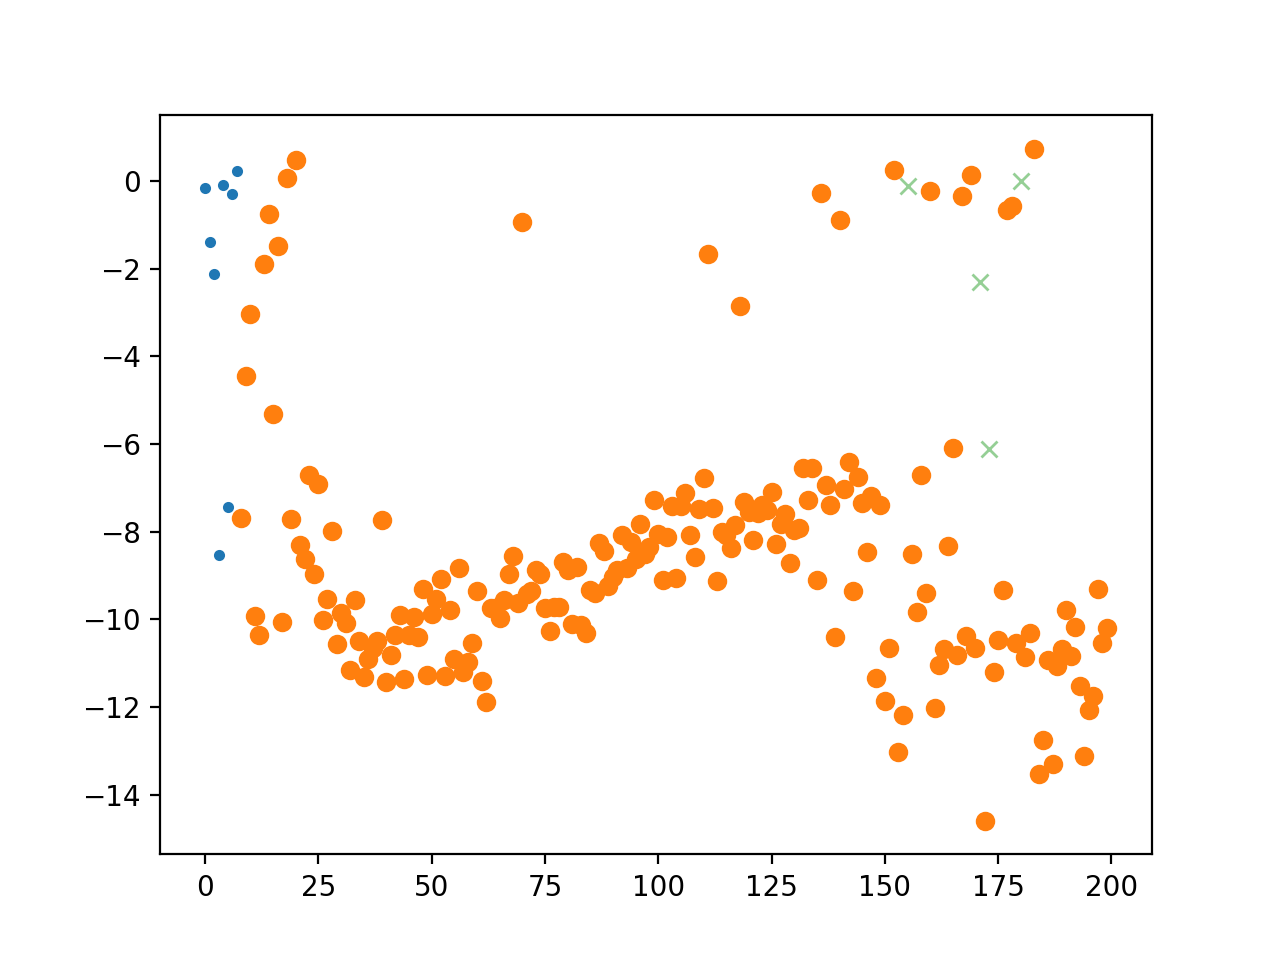

In [32]:
t=arange(len(manager.values))
ind = lambda s: array(manager.types)==s
close()
plot(t[ind('grid')],array(manager.values)[ind('grid')],'.')
plot(t[ind('Thompson')],array(manager.values)[ind('Thompson')],'o')
plot(t[ind('poll')],array(manager.values)[ind('poll')],'x',alpha=0.5)
plot(t[ind('random')],array(manager.values)[ind('random')],'^',alpha=0.1)

<IPython.core.display.Javascript object>


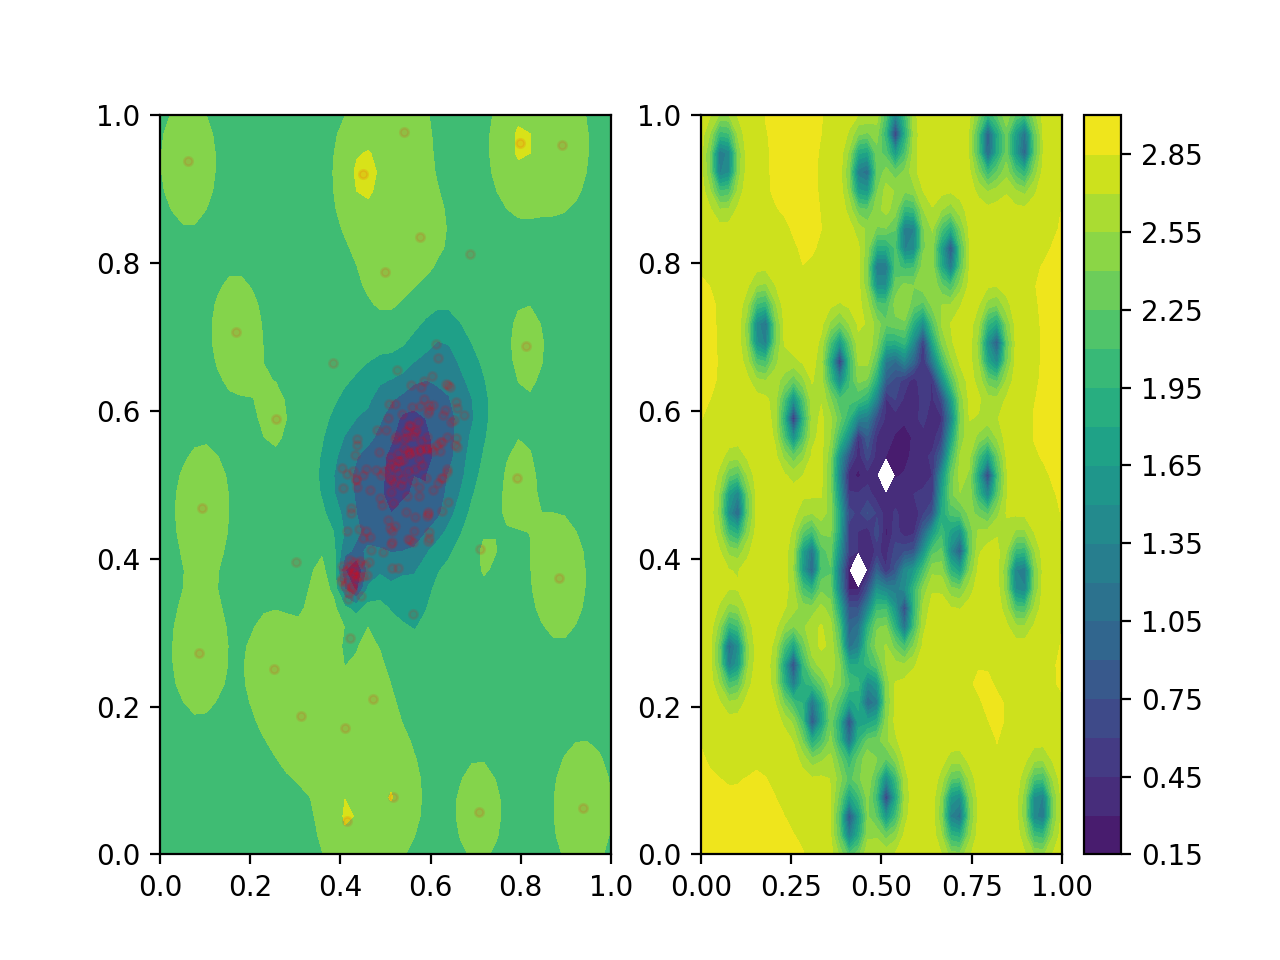

In [33]:
self = ipp_dview['chooser'][7]
self._set_gp_params(self.amp2,self.ls,self.noise,self.mean)
self.gp.compute(array(manager.complete))

xi = linspace(0, 1, 40)
yi = linspace(0, 1,40)

xx, yy = meshgrid(xi, yi)
m,v = self.gp.predict(array(manager.values),\
           array([xy for xy in zip(xx.flatten(),yy.flatten())]),\
           return_cov=False, return_var=True)
close()
subplot(121)
contourf(xx,yy,m.reshape(xx.shape))
plot(array(manager.complete)[:,0],array(manager.complete)[:,1],'r.',alpha=0.1)
#plot(x[:,0],x[:,1],'.')
subplot(122)
lv=sqrt(v.reshape(xx.shape))
lv[lv<self.rho*np.sqrt(self.noise)]=np.nan
contourf(xx,yy,lv,20,vmin=0)
colorbar()
#plot(x[:,0],x[:,1],'.')

<IPython.core.display.Javascript object>


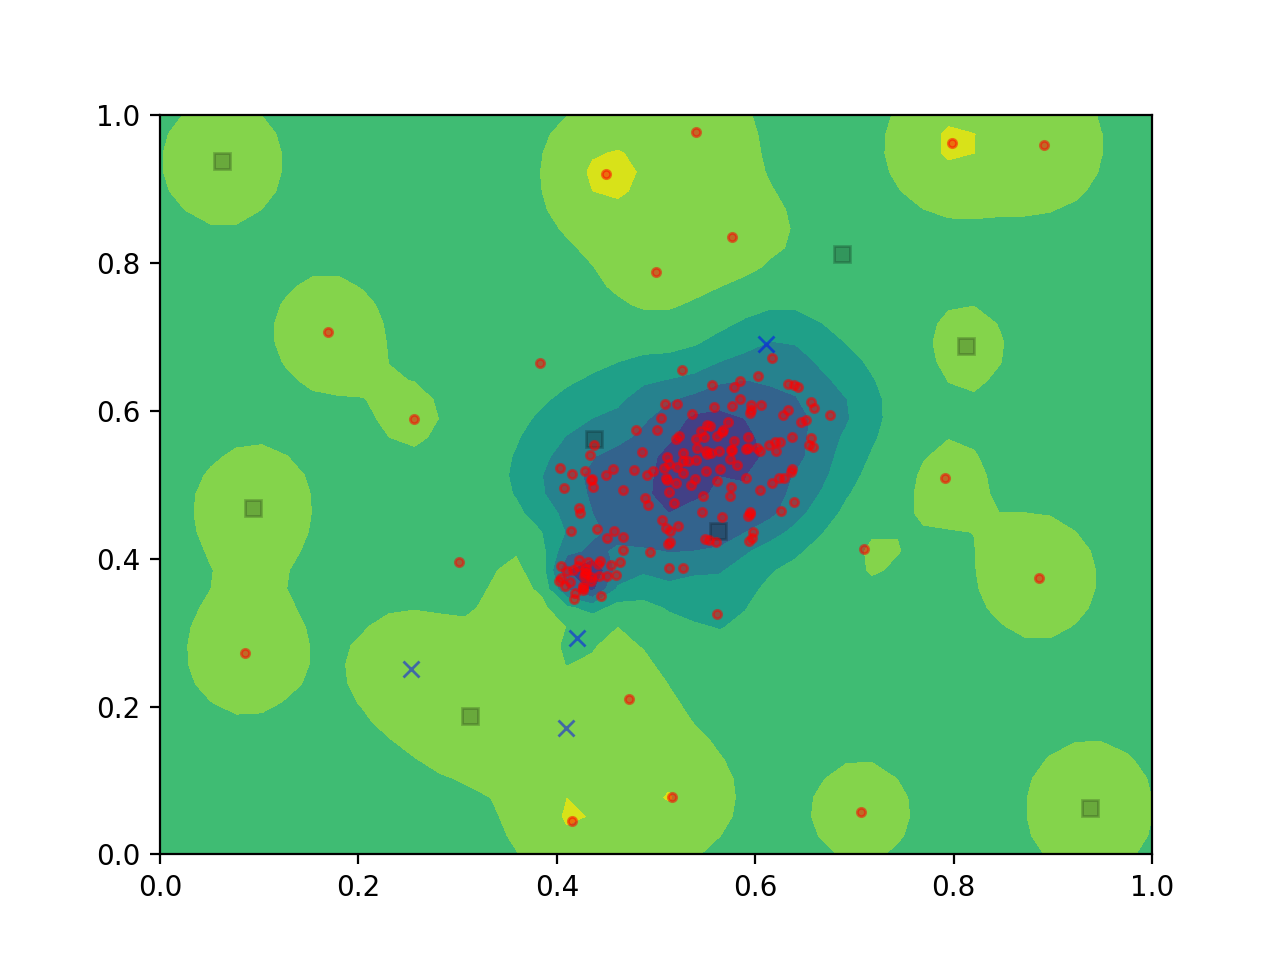

In [34]:
close()
subplot(111)
contourf(xx,yy,m.reshape(xx.shape))
plot(array(manager.complete)[ind('grid'),0],array(manager.complete)[ind('grid'),1],'ks',alpha=0.2)
plot(array(manager.complete)[ind('Thompson'),0],array(manager.complete)[ind('Thompson'),1],'r.',alpha=0.5)
plot(array(manager.complete)[ind('poll'),0],array(manager.complete)[ind('poll'),1],'bx',alpha=0.5)
plot(array(manager.complete)[ind('random'),0],array(manager.complete)[ind('random'),1],'o',color='0.5',alpha=0.2)


<IPython.core.display.Javascript object>


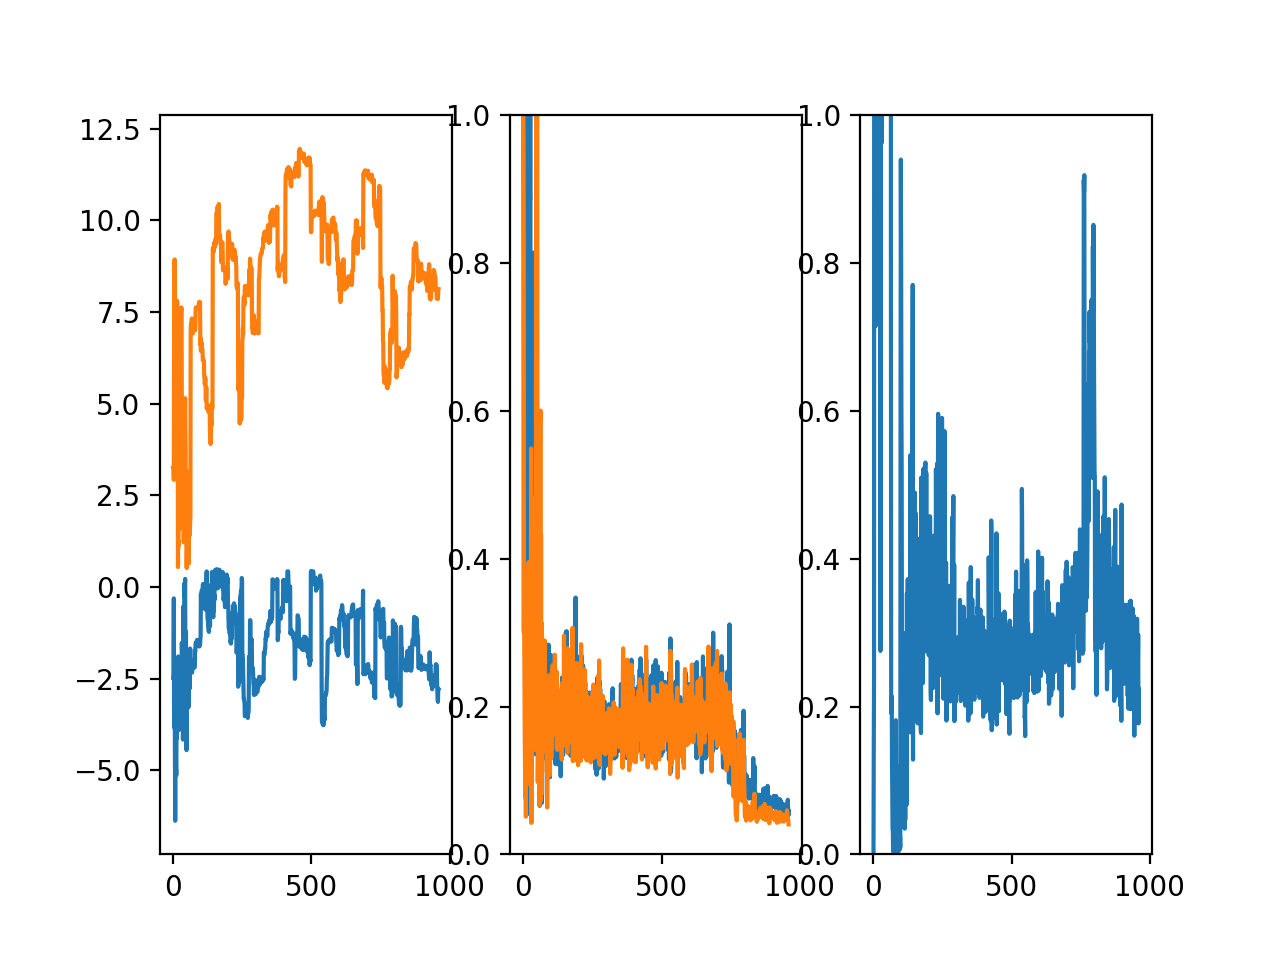

(0, 1)

In [35]:
c=self
close()
subplot(131)
plot(array(c.hyper_history)[:,0])
plot(array(c.hyper_history)[:,1])
subplot(132)
plot(array(c.hyper_history)[:,4])
plot(array(c.hyper_history)[:,3])
ylim(0,1)
subplot(133)
plot(array(c.hyper_history)[:,2])
ylim(0,1)
